In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyod.models.iforest import IForest

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

import shap

d:\anaconda3\envs\cbm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import the dataset
df = pd.read_csv('../data/ai4i2020.csv')

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# show duplicated rows
df['Product ID'].duplicated().sum()

0

# Exploratory Data Analysis
## Class Imbalance

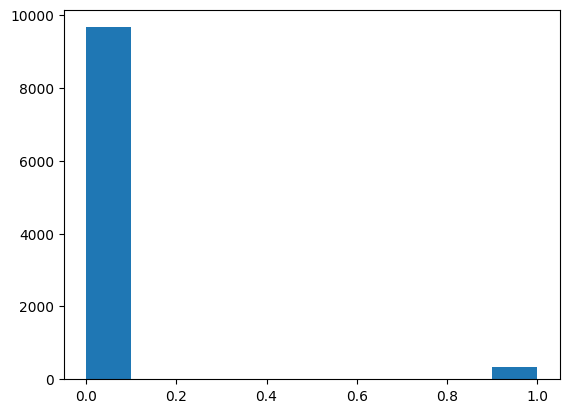

In [5]:
# show the overall machine failure distributions
plt.hist(df['Machine failure'])
plt.show()

## Product Quality

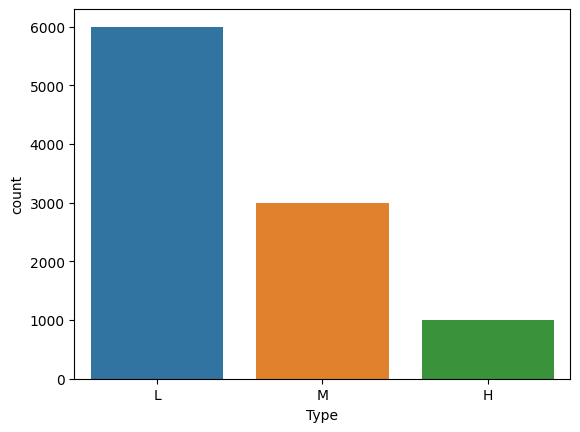

In [6]:
# show the distribution of product types L, M, H
sns.countplot(data=df, x='Type', order=df['Type'].value_counts().index)
plt.show()

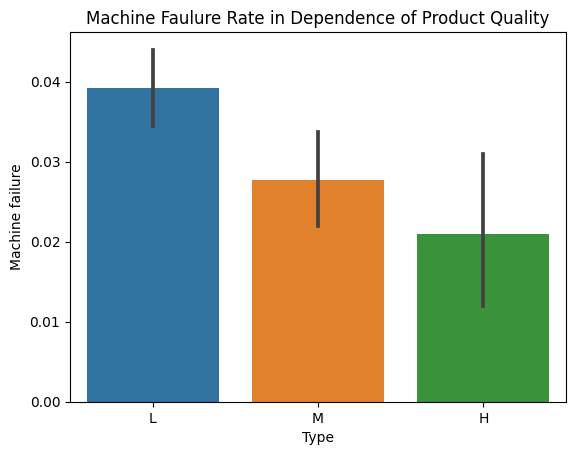

In [7]:
# show the machine failure distributions for the three different product quality categories L, M, H
plt.title('Machine Faulure Rate in Dependence of Product Quality')
sns.barplot(data=df, x='Type', y='Machine failure', order=df['Type'].value_counts().index)
plt.show()

# Feature Engineering
## Add Outlier Feature using Isolation Forest Algorithm

In [8]:
# define features i.e. physical parameters potentially leading to machine failure
features_numeric = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
df[features_numeric]

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9
...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14
9996,298.9,308.4,1632,31.8,17
9997,299.0,308.6,1645,33.4,22
9998,299.0,308.7,1408,48.5,25


In [9]:
# initialize and fit the iforest to detect outliers
iforest = IForest(contamination=0.05, n_jobs=-1)
iforest.fit(df[features_numeric])


IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=None, verbose=0)

In [10]:
outlier_scores = iforest.predict_proba(df[features_numeric])[:,1]

X has feature names, but IsolationForest was fitted without feature names


In [11]:
# add outlier labels to dataset
df['outlier_score'] = outlier_scores

In [12]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,outlier_score
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0.218663
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0.179736
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0.237727
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0.146272
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0.142298


In [13]:
features_numeric.append('outlier_score')

In [14]:
df[features_numeric + ['Machine failure']].head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],outlier_score,Machine failure
0,298.1,308.6,1551,42.8,0,0.218663,0
1,298.2,308.7,1408,46.3,3,0.179736,0
2,298.1,308.5,1498,49.4,5,0.237727,0
3,298.2,308.6,1433,39.5,7,0.146272,0
4,298.2,308.7,1408,40.0,9,0.142298,0


## Boxplots

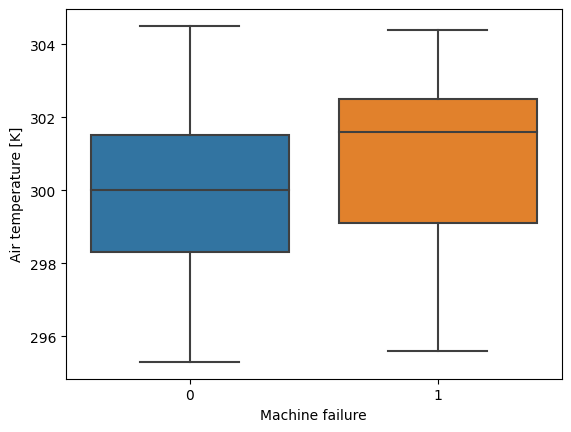

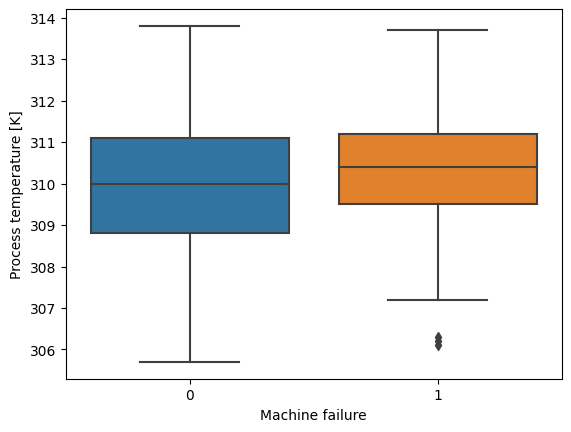

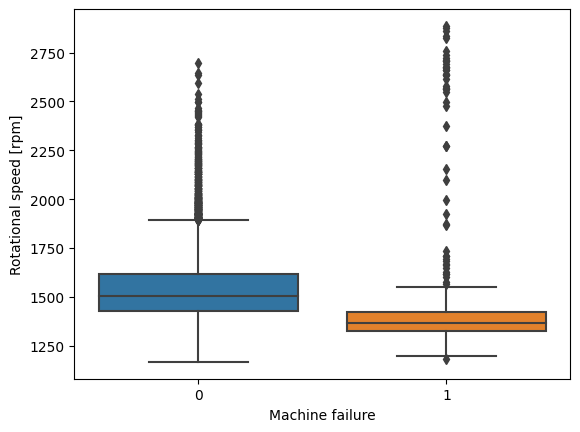

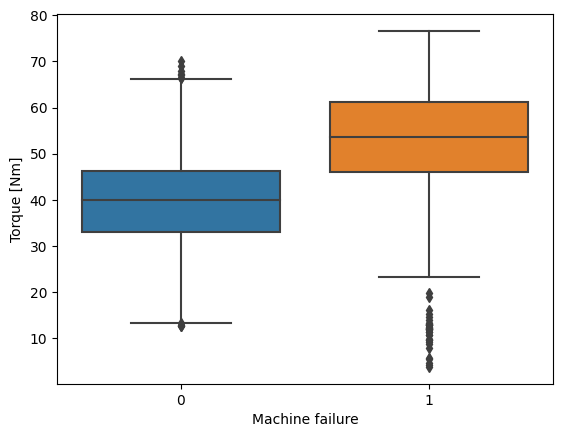

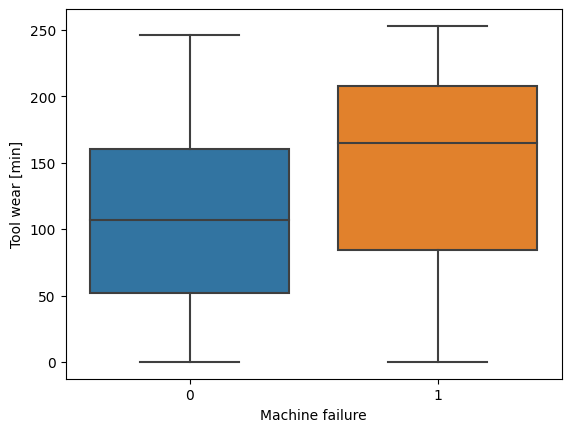

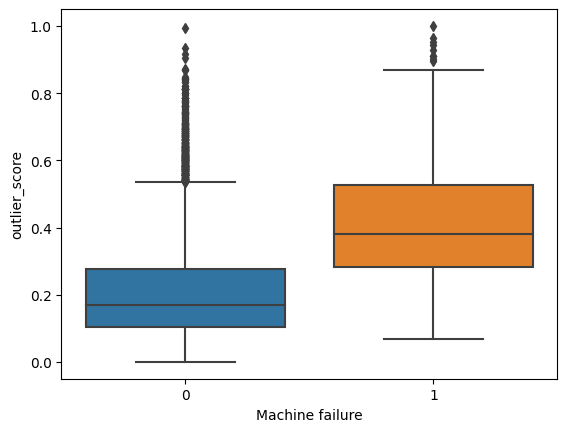

In [15]:
for f in features_numeric:
    sns.boxplot(df, y=f, x='Machine failure')
    plt.show()

In [42]:
# Let´s check how good we are at detecting machine failures by solely using the outlier score

df['Machine failure'][df['outlier_score'] > .3].sum()

237

In [47]:
import numpy as np
np.sum(df['outlier_score'] > .4)

1237

In [43]:
df['Machine failure'].sum()

339

Air temperature [K] Process temperature [K]
Air temperature [K] Rotational speed [rpm]
Air temperature [K] Torque [Nm]
Air temperature [K] Tool wear [min]
Air temperature [K] outlier_score
Process temperature [K] Rotational speed [rpm]
Process temperature [K] Torque [Nm]
Process temperature [K] Tool wear [min]
Process temperature [K] outlier_score
Rotational speed [rpm] Torque [Nm]
Rotational speed [rpm] Tool wear [min]
Rotational speed [rpm] outlier_score
Torque [Nm] Tool wear [min]
Torque [Nm] outlier_score
Tool wear [min] outlier_score


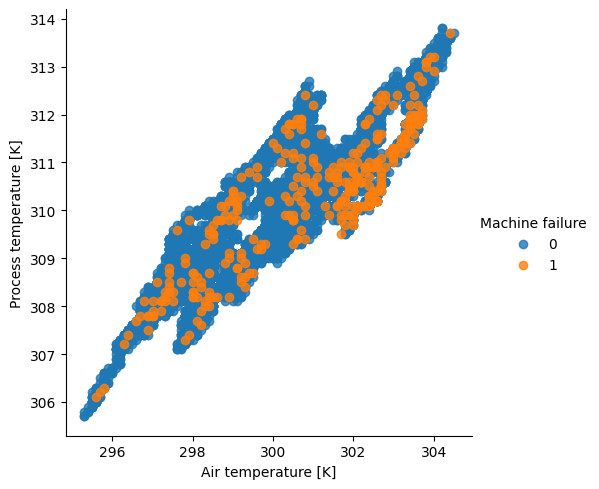

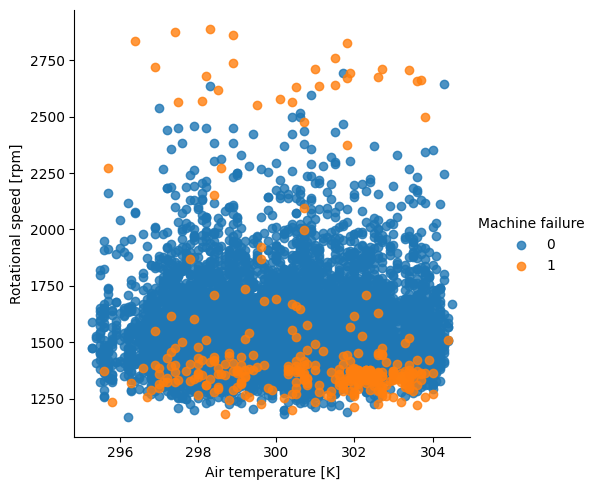

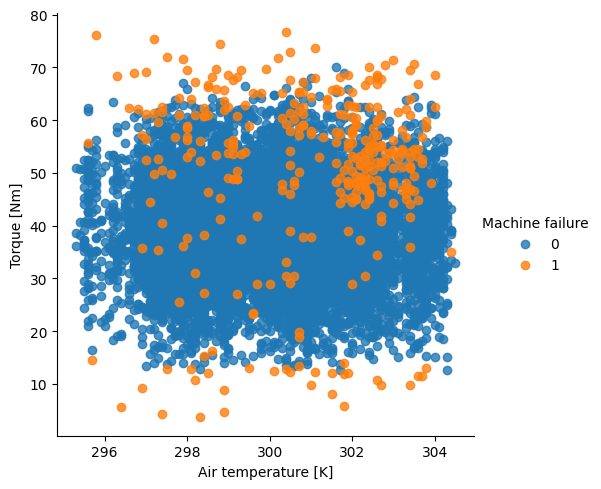

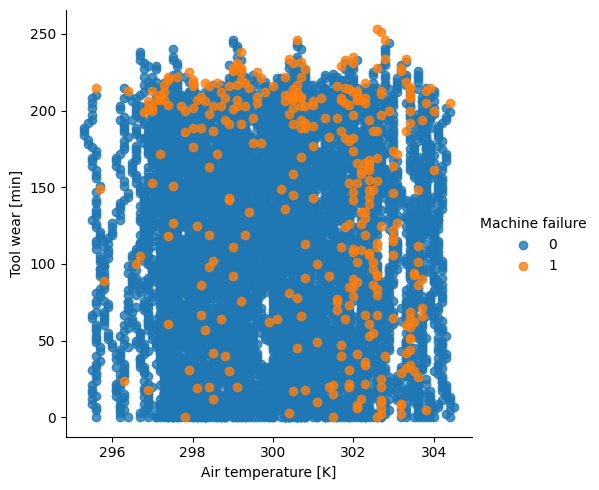

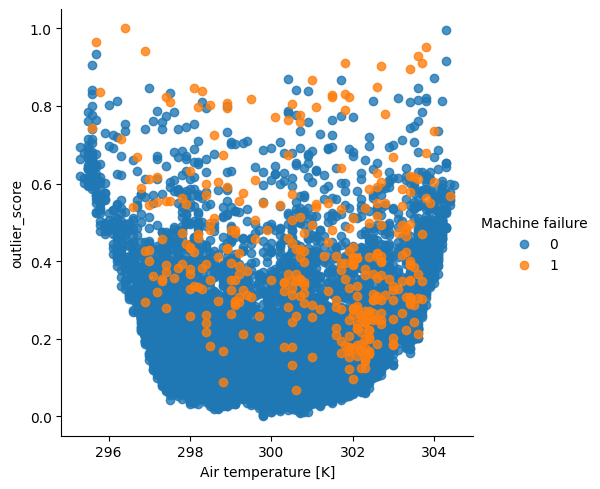

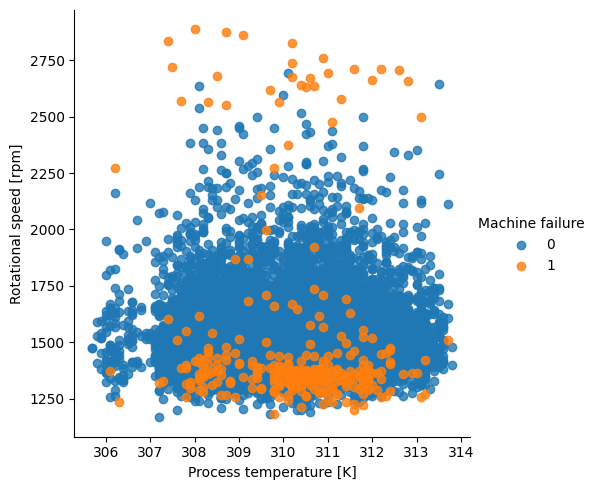

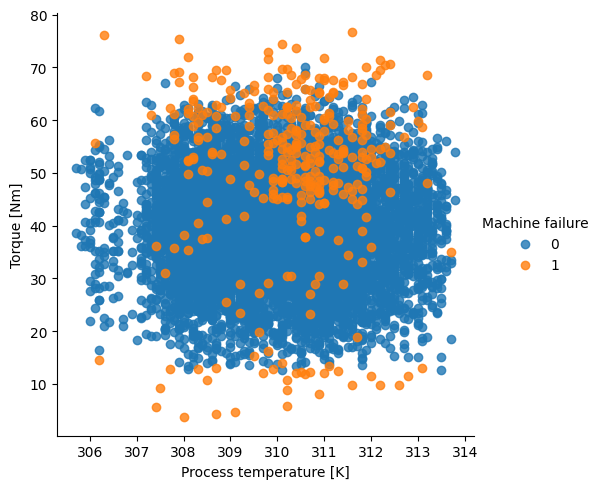

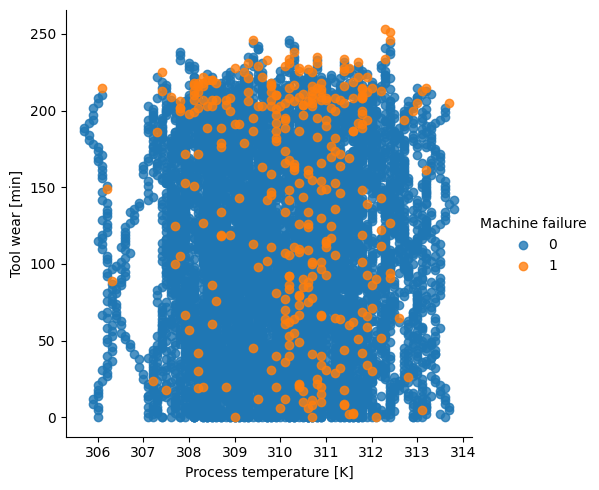

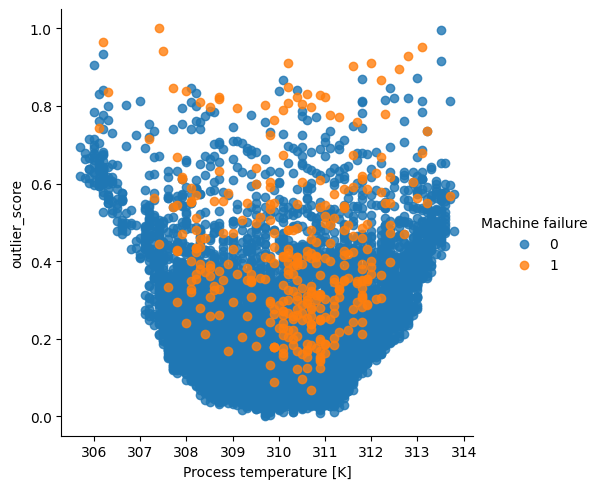

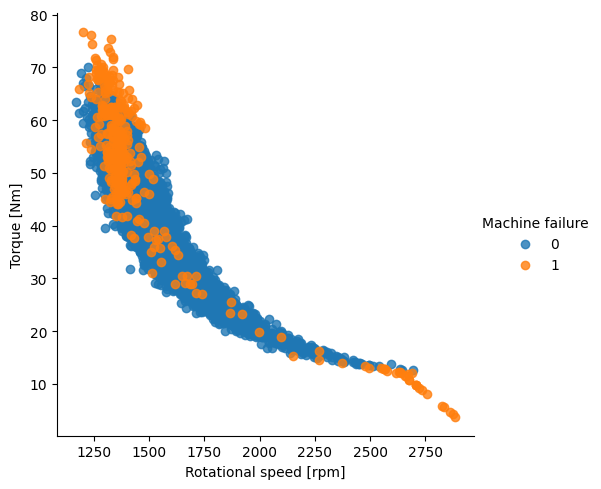

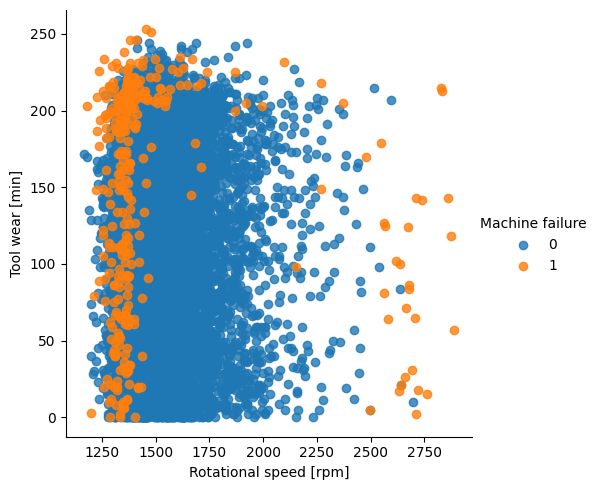

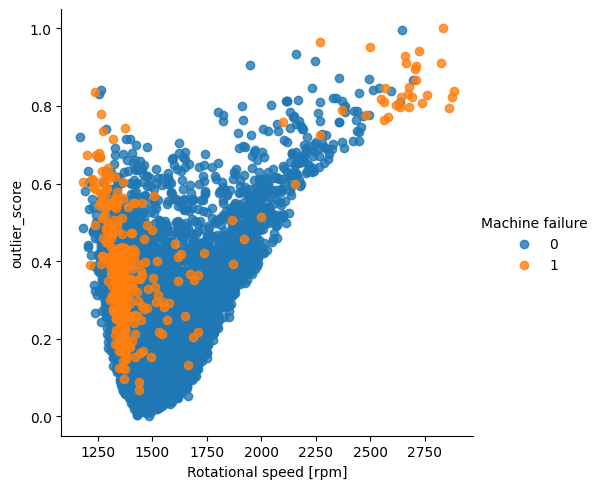

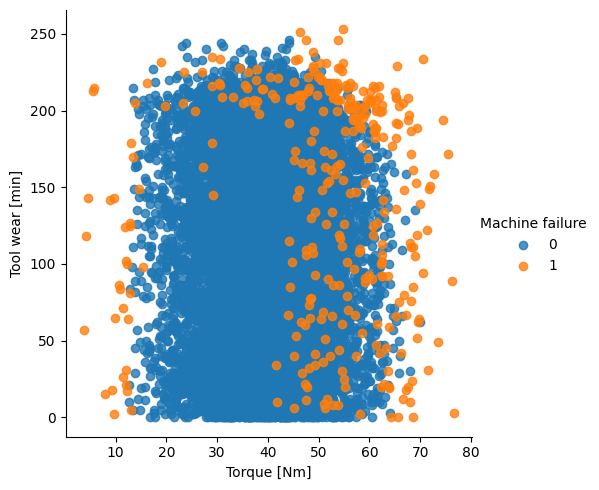

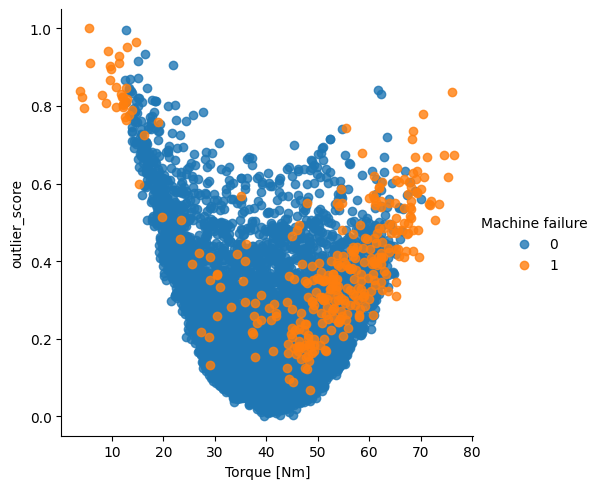

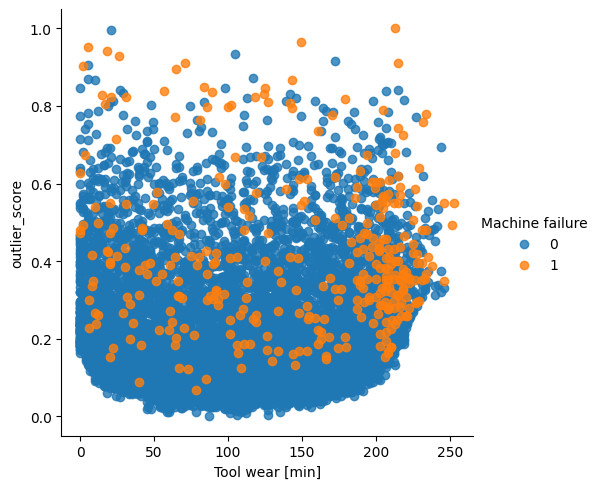

In [16]:
# Generate all combinations of features
combinations = list(itertools.combinations(features_numeric, 2))
for c in combinations:
    print(c[0], c[1])
    sns.lmplot(x=c[0], y=c[1], hue='Machine failure', data=df, fit_reg=False)

# Machine Learning Modeling

In [17]:
# separate features and target
X = df[features_numeric]
y = df['Machine failure']

In [18]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

## Fit Linear Classification Model

In [19]:
clf = LogisticRegression(class_weight='balanced', random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

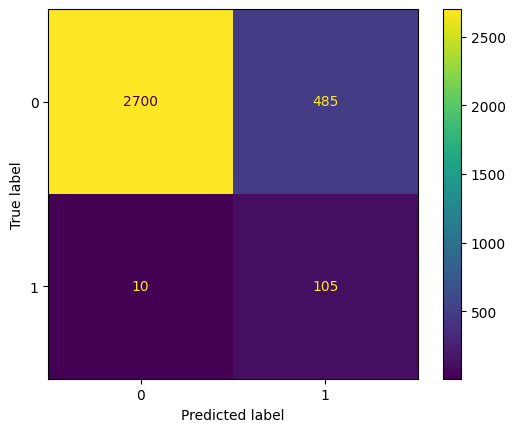

In [20]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

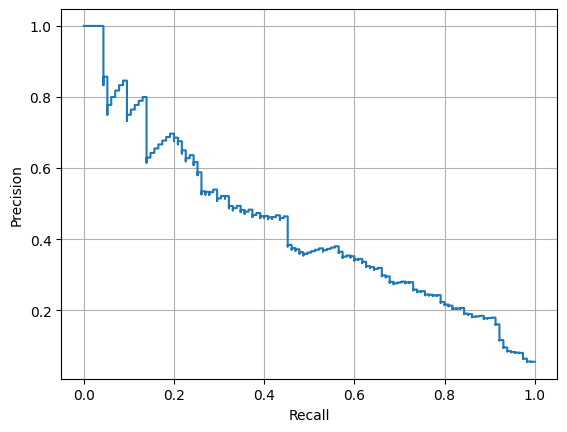

In [21]:
# precision recall curve
y_score = clf.decision_function(X_test)
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.grid()

## Fit Gradient Boosting Classifier

In [22]:
clf = GradientBoostingClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

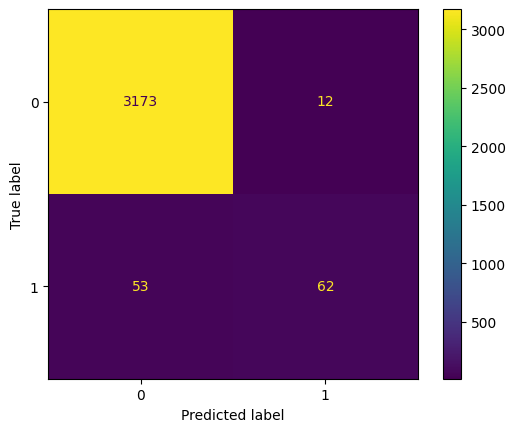

In [23]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

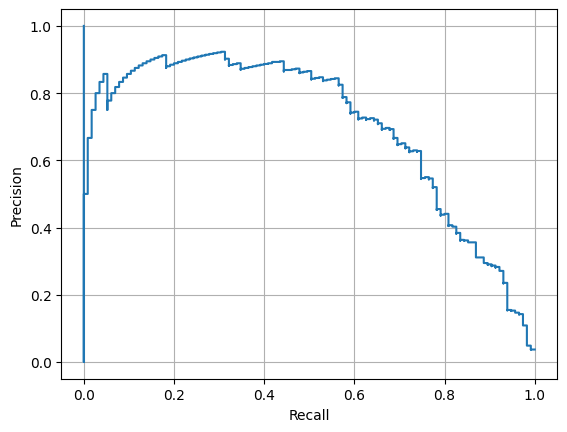

In [24]:
# precision recall curve
y_score = clf.decision_function(X_test)
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.grid()

# Explain Model Decisions
## Feature Importance - What are the Driving Factors for Machine Failure

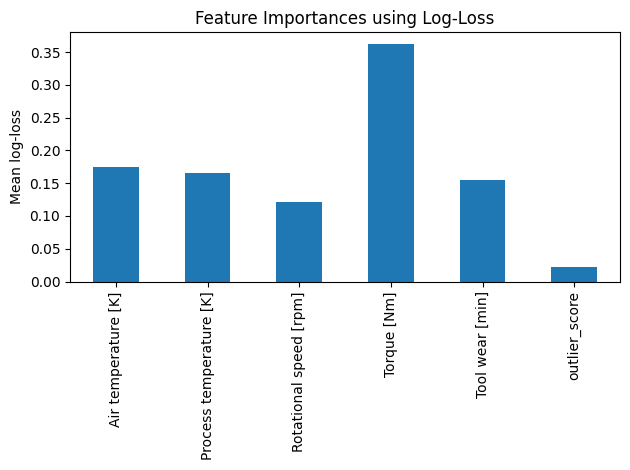

In [25]:
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=features_numeric)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Log-Loss")
ax.set_ylabel("Mean log-loss")
fig.tight_layout()

## Explainable AI using Shapley Values

In [26]:
explainer = shap.TreeExplainer(
    model = clf,
    data = X_test, 
    feature_perturbation = "interventional",
    model_output = 'probability')

In [27]:
shap_values = explainer.shap_values(X_test, check_additivity=True)

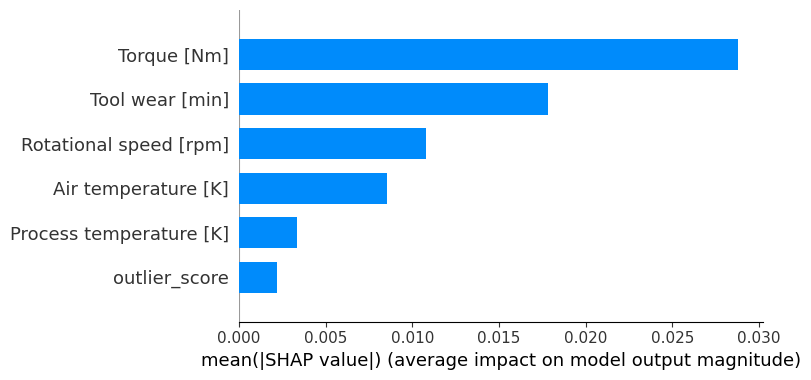

In [28]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='bar'
    )

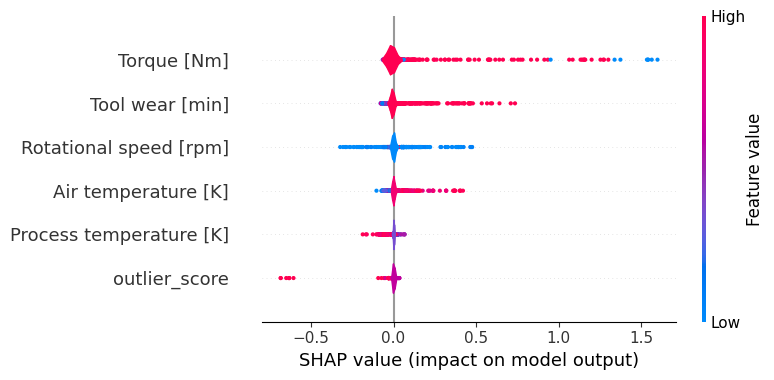

In [29]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='violin'
    )

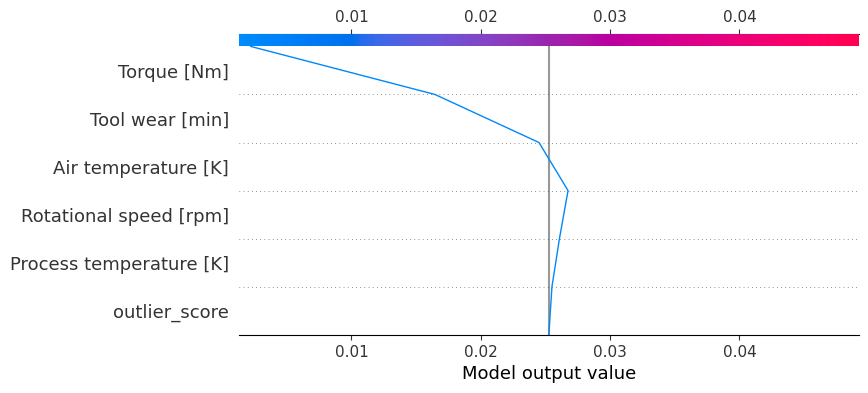

In [30]:
shap.decision_plot(
    base_value=explainer.expected_value,  
    shap_values=shap_values[1,:],
    feature_names=features_numeric)

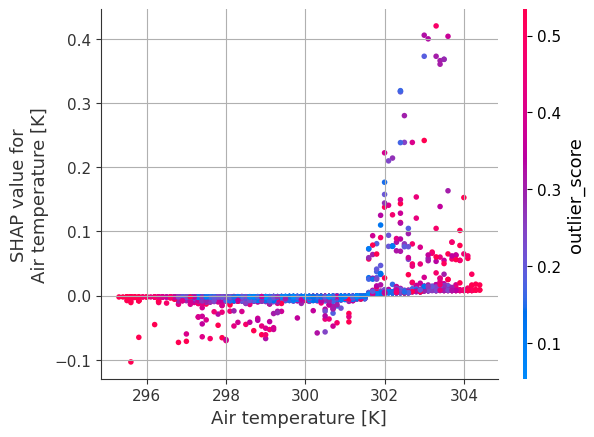

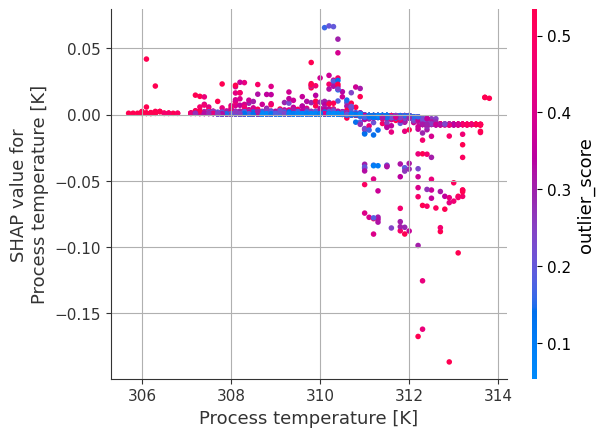

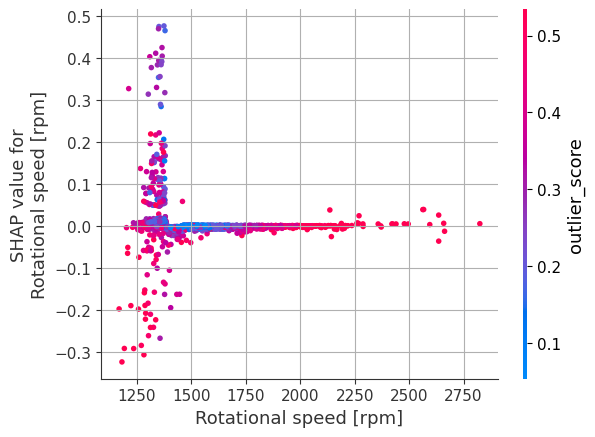

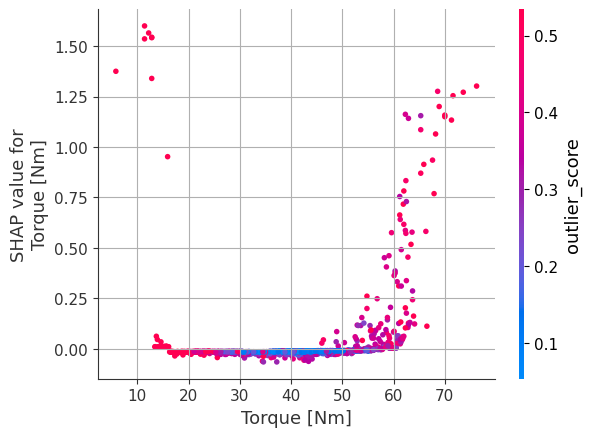

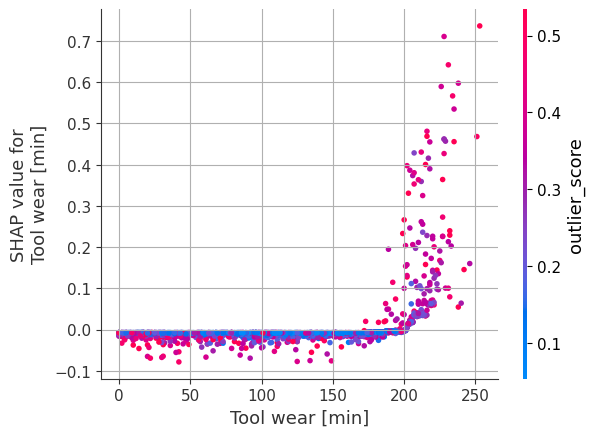

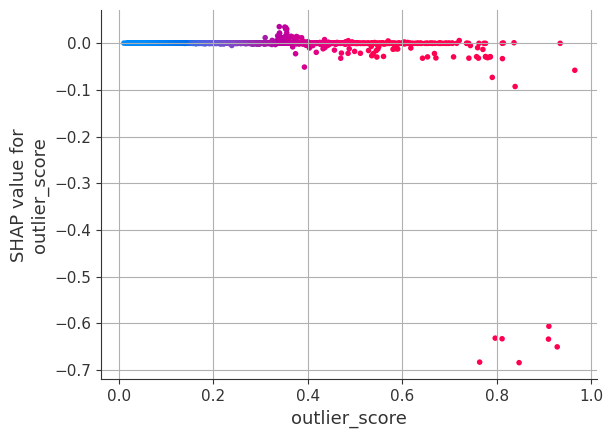

In [31]:

for f in features_numeric:
    fig, ax = plt.subplots(1,1)
    ax.grid()
    shap.dependence_plot(
        ind=f,
        shap_values=shap_values,
        features=X_test,
        interaction_index='outlier_score',
        ax=ax
    )
    
